# Machine Learning

## Prof. Neylson Crepalde

## Dimension reduction

Nesta aula, vamos trabalhar duas técnicas de redução de dimensionalidade relacionadas ao *Machine Learning*, o PCR (*Principal Components Regression*) e a PLS (*Partial Least Squares*).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

In [2]:
bd = pd.read_csv("https://raw.githubusercontent.com/neylsoncrepalde/ML_classes/master/Data/Hitters.csv")
bd.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
bd = pd.get_dummies(bd, drop_first=True)

In [4]:
bd = bd.dropna()
bd.shape

(263, 20)

In [5]:
y = bd.Salary
X = bd.drop(columns="Salary").astype("float64") # necessário converter p/ float64 para PCA e PLS

## PCR - Principal Components Regression

Não há um módulo que execute o PCR direto como no `R`. Precisamos executar o PCA e logo depois a regressão manualmente.

In [6]:
pca = PCA()
X_pca = pca.fit_transform(scale(X))

In [7]:
# Verifica os primeiros componentes gerados
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


In [8]:
# 10-fold CV, with shuffle
n = len(X_pca)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

reg = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1 * cross_val_score(reg, np.ones((n,1)), y.ravel(), cv=kf, scoring='neg_mean_squared_error').mean()    
mse.append(score)

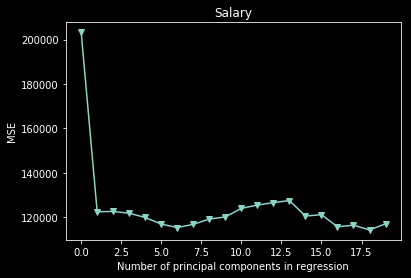

In [9]:
# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1 * cross_val_score(reg, X_pca[:,:i], y.ravel(), cv=kf, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.style.use("dark_background")
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.show()

In [10]:
# Percentual da variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

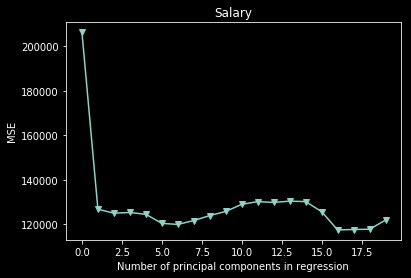

In [11]:
## Agora testando com dados de treino e teste
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1 * cross_val_score(reg, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1 * cross_val_score(reg, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [12]:
# Guarda o melhor resultado (quantidade de componentes com menor erro)
best_result = np.argmin(mse)

In [13]:
# Executa a regressão com o melhor número de componentes
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
reg = LinearRegression()
reg.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
yhat = reg.predict(X_reduced_test)
mean_squared_error(y_test, yhat)

109997.64255003608

### PLS - Partial Least Squares

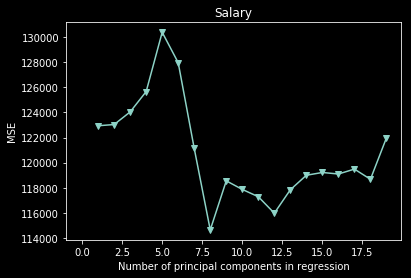

In [14]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = -1 * cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [15]:
best_pls = np.argmin(mse)
pls = PLSRegression(n_components=best_pls)
pls.fit(scale(X_train), y_train)
yhat_pls = pls.predict(scale(X_test))
mean_squared_error(y_test, yhat_pls)

118899.25571697434